In [26]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm, to_rgba
from rasterio.plot import show
import numpy as np
import rasterio
from rasterio.vrt import WarpedVRT
from rasterio.windows import from_bounds
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject
import xml.etree.ElementTree as ET

# Data prep for canada data

Data from https://open.canada.ca/data/en/dataset/d4f80bd3-17e3-a7e8-4bfe-d22a430678d5


In [18]:
# --- Parse QGIS QML palette ---
def parse_qgis_qml_palette(qml_file):
    """
    Returns dict: {int(value): {"name": label, "color": "#RRGGBB"}}
    """
    tree = ET.parse(qml_file)
    root = tree.getroot()
    # Find all paletteEntry nodes under a paletted rasterrenderer
    entries = root.findall(".//rasterrenderer[@type='paletted']/colorPalette/paletteEntry")
    mapping = {}
    for e in entries:
        val = int(e.attrib["value"])
        label = e.attrib.get("label", str(val))
        color = e.attrib.get("color", "#000000")
        # QGIS color may be "#RRGGBB" or "r,g,b,a"
        if "," in color:
            r, g, b, *rest = [int(x) for x in color.split(",")]
            a = int(rest[0]) if rest else 255
            color = to_rgba((r/255, g/255, b/255, a/255))
        else:
            # Ensure hex works for matplotlib (convert to RGBA)
            color = to_rgba(color)
        mapping[val] = {"name": label, "color": color}
    return mapping

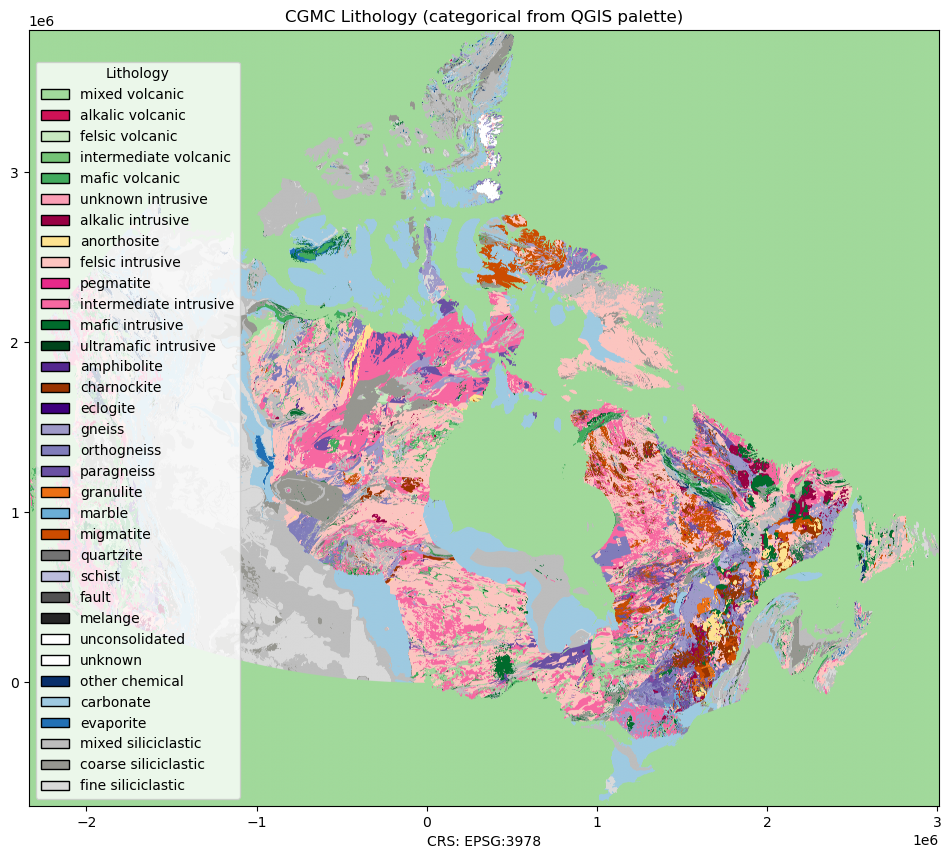

In [19]:
in_tiff = "2024_CGMC_Lithology_EPSG3978.tif"
qml_path = "compil_geologic_map_en.qml"
labels = parse_qgis_qml_palette(qml_path)

with rasterio.open(in_tiff) as src:
    data = src.read(1)
    nodata = src.nodata
    mask = np.ones_like(data, dtype=bool)
    if nodata is not None:
        mask &= (data != nodata)

    present_vals = np.unique(data[mask]).tolist()
    # Keep only the classes that have labels/colors defined
    vals = sorted(v for v in present_vals if v in labels)
    if not vals:
        raise ValueError("No labeled classes found in the raster for plotting. Check qml vs raster values.")

    # Build parallel lists for names/colors
    names = [labels[v]["name"] for v in vals]
    colors = [labels[v]["color"] for v in vals]

    # Create discrete colormap + norm:
    # We'll remap values -> 0..K-1 indices for compact colormap
    val_to_idx = {v: i for i, v in enumerate(vals)}
    remap = np.full_like(data, fill_value=-1, dtype=int)
    remap[mask] = np.vectorize(val_to_idx.get, otypes=[int])(data[mask])

    cmap = ListedColormap(colors)
    # Since remap is 0..K-1, boundaries are centered on integers
    boundaries = np.arange(len(vals) + 1) - 0.5
    norm = BoundaryNorm(boundaries, ncolors=cmap.N)

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(11, 9))
    show(remap, transform=src.transform, cmap=cmap, norm=norm, ax=ax)
    ax.set_title("CGMC Lithology (categorical from QGIS palette)")

    # Legend — only present classes (nice and tidy)
    handles = [Patch(facecolor=colors[i], edgecolor='k', label=names[i]) for i in range(len(vals))]
    # Tweak ncol if you have many classes
    ax.legend(handles=handles, title="Lithology", loc="lower left", frameon=True, ncol=1)

    ax.set_xlabel(f"CRS: {src.crs.to_string()}")
    ax.set_ylabel("")
    plt.tight_layout()
    plt.show()

# check new dataset

In [27]:
# --- Reproject to EPSG:4326 ---
dst_crs = "EPSG:4326"

proj_tif = "geol_canada_4326.tif"

with rasterio.open(in_tiff) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )

    profile = src.profile.copy()
    profile.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height,
        "compress": "deflate",
        "predictor": 2,
        "tiled": True,
        "blockxsize": 512,
        "blockysize": 512,
    })

    with rasterio.open(proj_tif, "w", **profile) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear,
        )

print("Reprojected raster saved as:", proj_tif)

Reprojected raster saved as: geol_canada_4326.tif


CRS: EPSG:4326
Bounds: BoundingBox(left=-173.45519671566532, bottom=35.83699207910679, right=-12.017054474044102, top=83.77371877320553)
Shape (rows, cols): 14554 49014
Number of bands: 1


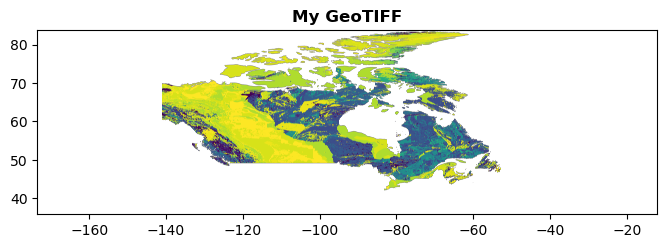

In [28]:
with rasterio.open(proj_tif) as src:
    print("CRS:", src.crs)
    print("Bounds:", src.bounds)
    print("Shape (rows, cols):", src.height, src.width)
    print("Number of bands:", src.count)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    img = show(src, ax=ax, title="My GeoTIFF")
    # cbar = plt.colorbar(img.get_images()[0], ax=ax, shrink=0.8)
    # cbar.set_label("Raster value")
    plt.show()

# Crop to cascadia only

In [29]:
cropped_tif = "canada_geol_bbox_4326.tif"

bbox_ll = (-130.0, 32.0, -113.0, 52.0)   # (minx, miny, maxx, maxy) in EPSG:4326

from pyproj import Transformer
with rasterio.open(proj_tif) as src:
    window = from_bounds(*bbox_ll, transform=src.transform)
    data = src.read(1, window=window)
    out_transform = src.window_transform(window)

    profile = src.profile.copy()
    profile.update({
        "height": data.shape[0],
        "width":  data.shape[1],
        "transform": out_transform,
        "compress": "deflate",
        "predictor": 2,
        "tiled": True,
        "blockxsize": 512,
        "blockysize": 512,
    })

    with rasterio.open(cropped_tif, "w", **profile) as dst:
        dst.write(data, 1)

print("Wrote:", cropped_tif)

Wrote: canada_geol_bbox_4326.tif


CRS: EPSG:4326
Bounds: BoundingBox(left=-130.0, bottom=35.837740972382676, right=-113.00113738709334, top=52.0)
Shape (rows, cols): 4907 5161
Number of bands: 1


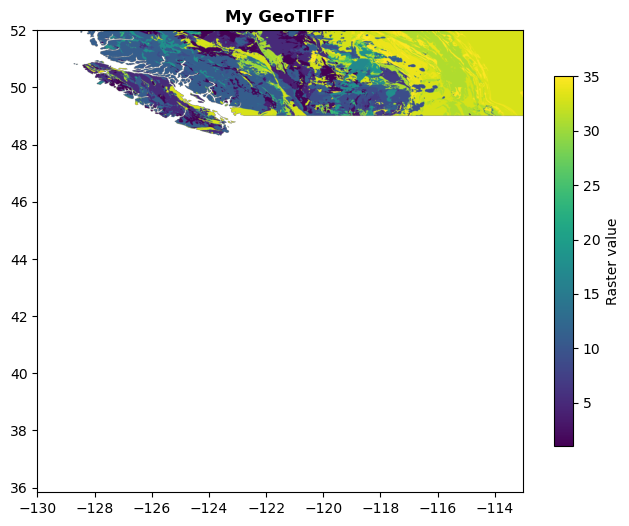

In [30]:
with rasterio.open(cropped_tif) as src:
    print("CRS:", src.crs)
    print("Bounds:", src.bounds)
    print("Shape (rows, cols):", src.height, src.width)
    print("Number of bands:", src.count)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    img = show(src, ax=ax, title="My GeoTIFF")
    cbar = plt.colorbar(img.get_images()[0], ax=ax, shrink=0.8)
    cbar.set_label("Raster value")
    plt.show()

# US